# Predicting Inspection Results
---

## Objectives

- I am tackling a binary classification problem involving restaurant health inspections using the data I processed in `01_EDA`.
- The two classes I am trying to predict will be Pass/Fail.
- If the model is successful, it can be used to aid restaurant owners in preparing for health inspections.

---

### Imports

In [367]:
import ast # for evaluating violation codes column properly

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve)

In [371]:
# Setting pandas to display all columns.
pd.set_option('display.max_columns', None)

In [373]:
def evaluate_model(model, X_test, y_test):
    """
    Docstring Credit: ChatGPT
    Evaluates the performance of a classification model on a test dataset. 
    This function computes key classification metrics (accuracy, precision, recall, F1 score) 
    and generates two plots: a ROC curve (if the model supports probability prediction) 
    and a confusion matrix.

    Parameters:
    - model: A trained classification model that implements the `predict` and, optionally, the `predict_proba` methods.
    - X_test: A pandas DataFrame or numpy array containing the test features.
    - y_test: A pandas Series or numpy array containing the true labels for the test set.

    Returns:
    - metrics_df: A pandas DataFrame containing the computed evaluation metrics (accuracy, precision, recall, F1 score).
    
    The function performs the following actions:
    1. **Prediction**: It uses the model to predict labels and probabilities (if available) on the test data.
    2. **Metrics Calculation**: It computes accuracy, precision, recall, and F1 score based on the predicted and true labels.
    3. **ROC Curve**: If the model supports `predict_proba`, it plots the Receiver Operating Characteristic (ROC) curve, which visualizes the tradeoff between the true positive rate and false positive rate.
    4. **Confusion Matrix**: It plots a heatmap of the confusion matrix, which shows the count of true positives, true negatives, false positives, and false negatives.
    """
    # Generating Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, pos_label = 1, zero_division=0),
        "Recall": recall_score(y_test, y_pred, pos_label = 1, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, pos_label = 1, zero_division=0)
    }
    metrics_df = pd.DataFrame(metrics, index=['Score'])
    
    fig, axes = plt.subplots(1, 2, figsize = (14, 6))
    
    # Plot ROC curve if probabilities are available
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label = 1)
        axes[0].plot(fpr, tpr, label = "ROC Curve", color = "blue", linewidth = 2)
        axes[0].plot([0, 1], [0, 1], linestyle = "--", color = "gray", label = "Random Guess")
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")
        axes[0].set_title("ROC Curve")
        axes[0].legend(loc = "lower right")
    else:
        print("ROC curve not available (model does not support predict_proba).")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels = [1, 0])
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues',
                xticklabels = ['Pass', 'Fail'], yticklabels = ['Pass', 'Fail'],
                cbar = False, ax = axes[1])
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    axes[1].set_title('Confusion Matrix')

    plt.show();

    return metrics_df

---
### Load Dataset

In [376]:
file_path = '../../data/processed_chicago.csv'

In [377]:
chicago = pd.read_csv('../../data/processed_chicago.csv')
chicago.head(3)

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,inspection_date,inspection_type,results,violations,name_cleaned,num_inspections,violation_count,violation_codes,severity_levels,is_reinspection,average_severity
0,2606026,FAMOUS GRILL,SAM'S FAMOUS GRILL,2961604,Restaurant,Risk 1 (High),2926 W 63RD ST,2024-11-06,Required Inspection to Open,Pass,No Violations,SAMS FAMOUS GRILL,4,0,[],[],False,0.000000
1,2605995,DUNKIN DONUTS,DUNKIN DONUTS,2835421,Restaurant,Risk 2 (Medium),1465 W 95TH ST,2024-11-06,Standard Re-Inspection,Pass,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...,DUNKIN DONUTS,13,7,"[39, 39, 41, 47, 49, 53, 55]","[4, 4, 4, 5, 4, 8, 1]",True,4.285714
2,2606039,STARBUCKS COFFEE #13710,STARBUCKS,1843207,Restaurant,Risk 2 (Medium),30 W ERIE ST,2024-11-06,Standard Inspection,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",STARBUCKS,8,4,"[38, 52, 55, 55]","[4, 8, 1, 1]",False,3.500000


In [380]:
# Baseline Accuracy
chicago['results'].value_counts(normalize = True)

results
Pass    0.769921
Fail    0.230079
Name: proportion, dtype: float64

- If we were to predict our positive class (Pass) every time we would be correct roughly 76.9% of the time.

---
### Preprocessing

In [382]:
# Encoding class labels (Pass = 1, Fail = 0)
chicago['results'] = chicago['results'].map({'Pass': 1, 'Fail': 0})
chicago['results'].value_counts(normalize = True)

results
1    0.769921
0    0.230079
Name: proportion, dtype: float64

In [384]:
# The cleanest solution I've found to handle the violation_codes column getting treated as a string.
chicago['violation_codes'] = chicago['violation_codes'].apply(ast.literal_eval)

# Flatten and get all unique violation codes
unique_codes = sorted(set(code for codes in chicago['violation_codes'] for code in codes))

# Create one-hot encoded columns
for code in unique_codes:
    column_name = f"violation_code_{code}"
    chicago[column_name] = chicago['violation_codes'].apply(lambda x: 1 if code in x else 0)

chicago.shape

(61705, 82)

In [386]:
# Checking codes were properly encoded
chicago.head(3)

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,inspection_date,inspection_type,results,violations,name_cleaned,num_inspections,violation_count,violation_codes,severity_levels,is_reinspection,average_severity,violation_code_1,violation_code_2,violation_code_3,violation_code_4,violation_code_5,violation_code_6,violation_code_7,violation_code_8,violation_code_9,violation_code_10,violation_code_11,violation_code_12,violation_code_13,violation_code_14,violation_code_15,violation_code_16,violation_code_17,violation_code_18,violation_code_19,violation_code_20,violation_code_21,violation_code_22,violation_code_23,violation_code_24,violation_code_25,violation_code_26,violation_code_27,violation_code_28,violation_code_29,violation_code_30,violation_code_31,violation_code_32,violation_code_33,violation_code_34,violation_code_35,violation_code_36,violation_code_37,violation_code_38,violation_code_39,violation_code_40,violation_code_41,violation_code_42,violation_code_43,violation_code_44,violation_code_45,violation_code_46,violation_code_47,violation_code_48,violation_code_49,violation_code_50,violation_code_51,violation_code_52,violation_code_53,violation_code_54,violation_code_55,violation_code_56,violation_code_57,violation_code_58,violation_code_59,violation_code_60,violation_code_61,violation_code_62,violation_code_63,violation_code_64
0,2606026,FAMOUS GRILL,SAM'S FAMOUS GRILL,2961604,Restaurant,Risk 1 (High),2926 W 63RD ST,2024-11-06,Required Inspection to Open,1,No Violations,SAMS FAMOUS GRILL,4,0,[],[],False,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2605995,DUNKIN DONUTS,DUNKIN DONUTS,2835421,Restaurant,Risk 2 (Medium),1465 W 95TH ST,2024-11-06,Standard Re-Inspection,1,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...,DUNKIN DONUTS,13,7,"[39, 39, 41, 47, 49, 53, 55]","[4, 4, 4, 5, 4, 8, 1]",True,4.285714,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2,2606039,STARBUCKS COFFEE #13710,STARBUCKS,1843207,Restaurant,Risk 2 (Medium),30 W ERIE ST,2024-11-06,Standard Inspection,0,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",STARBUCKS,8,4,"[38, 52, 55, 55]","[4, 8, 1, 1]",False,3.500000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [388]:
# Ordinal encoding for risk
risk_mapping = {'Risk 1 (High)': 3, 'Risk 2 (Medium)': 2, 'Risk 3 (Low)': 1}
chicago['risk'] = chicago['risk'].map(risk_mapping)
chicago['risk']

0        3
1        2
2        2
3        3
4        3
        ..
61700    2
61701    2
61702    3
61703    3
61704    2
Name: risk, Length: 61705, dtype: int64

In [390]:
# Creating X and y
X = chicago.drop(columns=['inspection_id', 'dba_name', 'aka_name', 'license', 'facility_type', 'address', 'inspection_date', 'results',
       'violations', 'name_cleaned', 'violation_codes', 'severity_levels'])
y = chicago['results']

In [392]:
# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

In [394]:
# Since one-hot encoding and ordinal encoding are already applied, only scale numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('ss', StandardScaler(), ['num_inspections', 'violation_count', 'average_severity']),
        ('ohe', OneHotEncoder(), ['inspection_type'])
    ],
    remainder='passthrough'  # Keep the already preprocessed columns as they are
)

---
### Modelling

In [397]:
# Model pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [399]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'classifier__C': [ 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print(grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}


---
### Model Evaluation

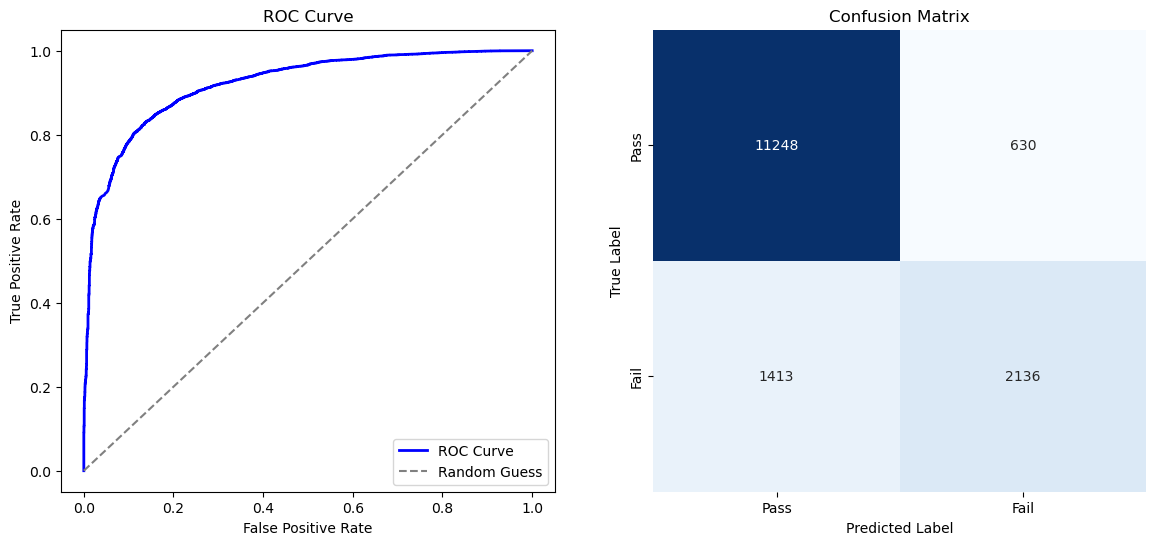

,Accuracy,Precision,Recall,F1 Score
Score,0.86757,0.888397,0.946961,0.916745


In [402]:
# Evaluation
metrics_df = evaluate_model(best_model, X_test, y_test)
metrics_df

---
### Interpretations and Conclusion